In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import os
import math
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt 
import numpy as np
from collections import Counter 

from sklearn.ensemble import RandomForestRegressor , GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor


from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# suppress warnings and ignore them
import warnings
warnings.filterwarnings("ignore")

In [2]:
# set the current working directory
os.chdir("C:/Users/Pranav/Desktop/Cab Fare Project")

In [3]:
#Loading the data:
train  = pd.read_csv("train_cab.csv")
test   = pd.read_csv("test.csv")

In [4]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1.0


In [5]:
# checking data types
train.dtypes

fare_amount           object
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      float64
dtype: object

In [6]:
# checking missing values
train.isnull().sum()

fare_amount          24
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
passenger_count      55
dtype: int64

In [7]:
#Convert fare_amount from object datatype to numeric datatype
train["fare_amount"] = pd.to_numeric(train["fare_amount"],errors = "coerce")  

In [8]:
# Here for pickup_datetime variable , we need to change its data type to datetime
train['pickup_datetime'] =  pd.to_datetime(train['pickup_datetime'], format='%Y-%m-%d %H:%M:%S UTC' , errors = 'coerce')

In [9]:
test["pickup_datetime"] = pd.to_datetime(test["pickup_datetime"],format= "%Y-%m-%d %H:%M:%S UTC" , errors = 'coerce')

In [10]:
train.dtypes

fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count             float64
dtype: object

In [11]:
# checking missing values
train.isnull().sum()

fare_amount          25
pickup_datetime       1
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
passenger_count      55
dtype: int64

In [12]:
# drop null values
train = train.dropna(subset=["fare_amount","pickup_datetime","passenger_count"])

In [13]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1.0


We separete the pickup_datetime into separate columns. After that we remove the pickup_datetime variable

In [14]:
train['year'] = train['pickup_datetime'].dt.year

train['Month'] = train['pickup_datetime'].dt.month
train['Day'] = train['pickup_datetime'].dt.dayofweek
train['Hour'] = train['pickup_datetime'].dt.hour
train = train.drop(columns = ["pickup_datetime"])

In [15]:
# Doing the same thing for test dataset
test['year'] = test['pickup_datetime'].dt.year

test['Month'] = test['pickup_datetime'].dt.month
test['Day'] = test['pickup_datetime'].dt.dayofweek
test['Hour'] = test['pickup_datetime'].dt.hour
test = test.drop(columns = ["pickup_datetime"])

In [16]:
# unique values of year
train['year'].unique()

array([2009, 2010, 2011, 2012, 2013, 2014, 2015], dtype=int64)

In [17]:
# label encoding the year values for train as well as test data
train['year'] = train['year'].astype('category')
train['year'] = train["year"].cat.codes

test['year'] = test['year'].astype('category')
test['year'] = test["year"].cat.codes

In [18]:
train.shape

(15986, 10)

To calculate the distance between pickup coordinates and dropoff coordinates we need to use haversine formula

In [19]:
def distance(pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude):
    data = [train, test]
    for i in data:
        R = 6371  #radius of earth in kilometers
        
        phi1 = np.radians(i[pickup_latitude])
        phi2 = np.radians(i[dropoff_latitude])
    
        delta_phi = np.radians(i[dropoff_latitude]-i[pickup_latitude])
        delta_lambda = np.radians(i[dropoff_longitude]-i[pickup_longitude])
    
        #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
        a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    
        #c = 2 * atan2( √a, √(1−a) )
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
        #d = R*c
        #distance in kilometers
        d = (R * c) 
        i['Distance'] = d

In [20]:
distance('pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')

In [21]:
train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,Month,Day,Hour,Distance
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1.0,0,6,0,17,1.030764
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1.0,1,1,1,16,8.450134
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2.0,2,8,3,0,1.389525
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1.0,3,4,5,4,2.799270
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1.0,1,3,1,7,1.999157


## Outlier Analysis

#### case 1:
Latitudes range in the interval (-90,90) and Longitudes range in the interval (-180,180)

In [22]:
train = train.drop(train.loc[(train["pickup_latitude"] < -90) | (train["pickup_latitude"] > 90)].index , axis = 0)
train = train.drop(train.loc[(train["pickup_longitude"] < -180) | (train["pickup_longitude"] > 180)].index , axis = 0)

train = train.drop(train.loc[(train["dropoff_latitude"] < -90) | (train["dropoff_latitude"] > 90)].index , axis = 0)
train = train.drop(train.loc[(train["dropoff_longitude"] < -180) | (train["dropoff_longitude"] > 180)].index , axis = 0)

In [23]:
train.shape # looks like there was 1 such value

(15985, 11)

#### case 2:
check for distances which are very very large. This is mostly because of the missing information about coordinates

In [24]:
train.sort_values(by = "Distance")

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,Month,Day,Hour,Distance
4086,45.00,-73.776293,40.645693,-73.776293,40.645693,2.0,0,6,0,12,0.000000
11437,5.30,-73.919393,40.731357,-73.919393,40.731357,2.0,1,10,2,14,0.000000
13264,9.00,0.000000,0.000000,0.000000,0.000000,6.0,4,2,3,22,0.000000
799,3.00,0.000000,0.000000,0.000000,0.000000,5.0,4,12,6,23,0.000000
10959,5.30,-73.974772,40.759440,-73.974772,40.759440,1.0,1,11,2,13,0.000000
10964,4.10,0.000000,0.000000,0.000000,0.000000,1.0,0,9,3,9,0.000000
6744,14.90,0.000000,0.000000,0.000000,0.000000,1.0,0,7,1,18,0.000000
808,6.10,-73.984433,40.771084,-73.984433,40.771084,1.0,1,10,4,2,0.000000
9863,6.50,0.000000,0.000000,0.000000,0.000000,1.0,1,12,3,6,0.000000
7458,3.70,0.000000,0.000000,0.000000,0.000000,1.0,1,9,1,8,0.000000


Clearly the distance drastically changes from around 130 to 4447. Hence we will consider distances above 130km to be very high

There are very high distances in 8000's because either the pickup or the dropoff coordinates are missing(considered as 0's)

In [25]:
# distances above 130 km look unlikely.
train = train.drop(train.loc[(train["Distance"] > 130)].index , axis = 0)

In [26]:
train.shape

(15960, 11)

#### case 3:
checking for outliers in passenger counts

In [27]:
train["passenger_count"].unique()

array([1.000e+00, 2.000e+00, 3.000e+00, 6.000e+00, 5.000e+00, 4.000e+00,
       2.360e+02, 4.560e+02, 5.334e+03, 0.000e+00, 5.350e+02, 3.540e+02,
       5.540e+02, 5.300e+01, 3.500e+01, 3.450e+02, 5.345e+03, 5.360e+02,
       4.300e+01, 5.800e+01, 5.370e+02, 8.700e+01, 5.312e+02, 1.300e+00,
       1.200e-01, 5.570e+02])

We can see that some of the passenger_count values are in decimals. We remove those

In [28]:
train.drop(train[((train["passenger_count"] * 10) % 10) != 0].index , inplace = True)

In [29]:
train["passenger_count"].unique()

array([1.000e+00, 2.000e+00, 3.000e+00, 6.000e+00, 5.000e+00, 4.000e+00,
       2.360e+02, 4.560e+02, 5.334e+03, 0.000e+00, 5.350e+02, 3.540e+02,
       5.540e+02, 5.300e+01, 3.500e+01, 3.450e+02, 5.345e+03, 5.360e+02,
       4.300e+01, 5.800e+01, 5.370e+02, 8.700e+01, 5.570e+02])

Generally a cab accommodates upto 6 passengers

In [30]:
# maximum 6 persons can be there in the cab 
train.drop(train[(train["passenger_count"] > 6)].index , inplace = True)

In [31]:
train.shape

(15939, 11)

#### case 4:
Check outliers in fare amount

In [32]:
train.sort_values(by = "fare_amount")

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,Month,Day,Hour,Distance
13032,-3.00,-73.995062,40.740755,-73.995885,40.741357,4.0,4,8,4,8,0.096377
2039,-2.90,-73.789450,40.643498,-73.788665,40.641952,1.0,1,3,1,23,0.184225
2486,-2.50,-74.000031,40.720631,-73.999809,40.720539,1.0,6,3,6,5,0.021244
10002,0.00,-73.987115,40.738808,-74.005911,40.713960,1.0,1,2,0,14,3.184763
2780,0.01,-73.939041,40.713963,-73.941673,40.713997,1.0,6,5,4,15,0.221878
1427,1.14,-73.862829,40.769014,-73.982075,40.723854,1.0,5,5,5,15,11.230687
6226,2.50,-73.982657,40.731395,-73.982282,40.731852,1.0,0,11,2,23,0.059839
14530,2.50,-74.010751,40.702421,-74.010743,40.702385,1.0,5,6,5,1,0.004059
6007,2.50,0.000000,0.000000,0.000000,0.000000,1.0,3,11,2,12,0.000000
503,2.50,-73.998720,40.624708,-73.998720,40.624708,1.0,1,1,1,1,0.000000


The base fare price is 2.5 dollors. We consider maximum value to be 453

In [33]:
train = train.drop(train.loc[(train["fare_amount"] < 2.5) | (train["fare_amount"] > 453) ].index , axis = 0)

#### Case 5:
Check where the distance is 0 but the fare is positive
There may be 2 reasons
* pickup and dropoff coordinates are same
* pickup and dropoff information is not entered

In [34]:
Counter(((train["Distance"] == 0) |
      (train["pickup_latitude"] == 0)|
      (train["pickup_longitude"] == 0)|
      (train["dropoff_latitude"] == 0)|
      (train["dropoff_longitude"] == 0))
      & train["fare_amount"] !=0)

Counter({False: 15476, True: 455})

There are 455 such values. It wouldn't be wise to delete them

In [35]:
train[((train["Distance"] == 0) |
      (train["pickup_latitude"] == 0)|
      (train["pickup_longitude"] == 0)|
      (train["dropoff_latitude"] == 0)|
      (train["dropoff_longitude"] == 0))
      & train["fare_amount"] !=0 ]

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,Month,Day,Hour,Distance
11,5.50,0.000000,0.000000,0.000000,0.000000,3.0,3,12,0,11,0.0
15,5.00,0.000000,0.000000,0.000000,0.000000,1.0,4,11,5,12,0.0
105,52.00,-74.035839,40.747320,-74.035839,40.747320,1.0,0,3,2,0,0.0
124,8.00,0.000000,0.000000,0.000000,0.000000,2.0,4,1,3,17,0.0
191,6.50,-73.998488,40.726303,-73.998488,40.726303,1.0,5,1,2,21,0.0
192,3.70,0.000000,0.000000,0.000000,0.000000,5.0,1,9,6,17,0.0
270,7.50,-73.995892,40.746454,-73.995892,40.746454,1.0,3,8,5,1,0.0
273,8.10,0.000000,0.000000,0.000000,0.000000,4.0,0,10,4,18,0.0
290,6.90,-73.982432,40.745747,-73.982432,40.745747,1.0,0,12,0,12,0.0
357,8.50,0.000000,0.000000,0.000000,0.000000,1.0,4,7,3,16,0.0


After making search online with the latitude and longitude coordinates, the area which which the data is collected appears to be New York and neighbouring areas.

Obviously the amount given to US is in dollars. Also the base fare price in New York as per the Google search is around $2.5 


For every extra km a charge of $1.56 is levied

Instead of deleting better strategy would be imputating distance values

distance = (fare_amount - 2.5)/ 1.56

In [36]:
subset = train.loc[((train["Distance"] == 0) |
      (train["pickup_latitude"] == 0)|
      (train["pickup_longitude"] == 0)|
      (train["dropoff_latitude"] == 0)|
      (train["dropoff_longitude"] == 0))
      & train["fare_amount"] !=0]

In [37]:
subset["Distance"] = subset.apply(lambda x: (x["fare_amount"] -2.5)/1.56 , axis =1)

In [38]:
# updating the values in the training set
train.update(subset)

# Exploratory Data Analysis

### Analysis of Continuous variables

In [39]:
numerical_variables = ["pickup_latitude",
                       "pickup_longitude",
                       "dropoff_latitude",
                       "dropoff_longitude",
                       "Distance",
                       "fare_amount"]

In [40]:
# Correlation analysis
# correlation plot
df_corr = train.loc[:,numerical_variables]

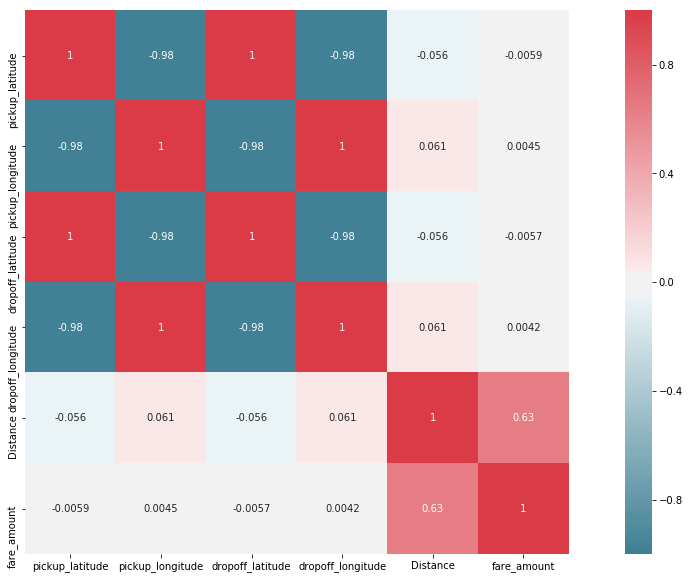

In [41]:
%matplotlib inline
# Set the width and height of the plot
f , ax = plt.subplots(figsize = (20,10))

# Generate correlation matrix
corr = df_corr.corr()

# Plot using seaborn library
sn.heatmap(corr,mask = np.zeros_like(corr,dtype = np.bool), cmap = sn.diverging_palette(220,10,as_cmap = True),
           square = True , ax = ax , vmin = -1 , vmax = 1 , annot = True)

We observe that the coordinates of latitudes and longitudes are highly correlated to each other which would negatively affect the model

Hence we need to drop these columns

In [42]:
# we drop all latitudes and longitudes because they are highly correlated with each other
# they will negatively affect the model
# moreover we have calculated the haversine distance and we don't need these variables

train = train.drop(columns = ["pickup_longitude","pickup_latitude","dropoff_longitude", "dropoff_latitude"])
test = test.drop(columns = ["pickup_longitude","pickup_latitude","dropoff_longitude", "dropoff_latitude"])

In [43]:
train.shape

(15931, 7)

#### Does Distance covered affect fare_amount ?

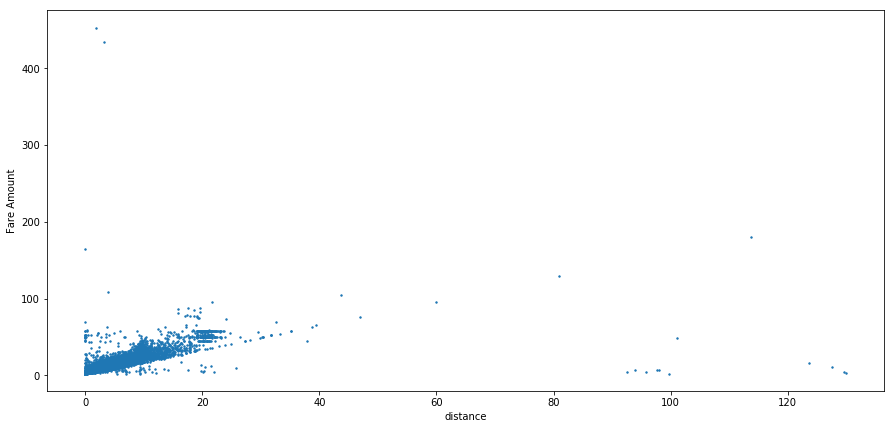

In [44]:
plt.figure(figsize=(15,7))
plt.scatter(x=train['Distance'], y=train['fare_amount'], s=2)
plt.xlabel('distance')
plt.ylabel('Fare Amount');

### Analysis of Categorical variables

#### 1. Does the passenger_count affect the fare_amount

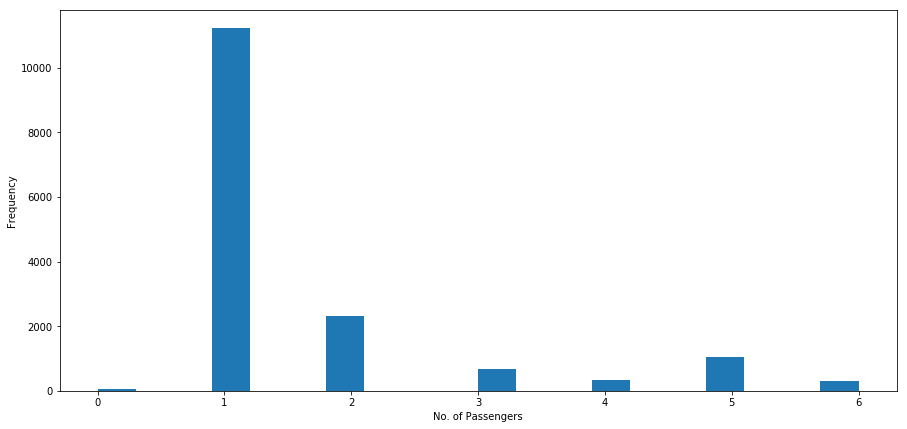

In [45]:
%matplotlib inline
plt.figure(figsize=(15,7))
plt.hist(train['passenger_count'], bins=20)
plt.xlabel('No. of Passengers')
plt.ylabel('Frequency')
plt.xticks(range(0, 7));

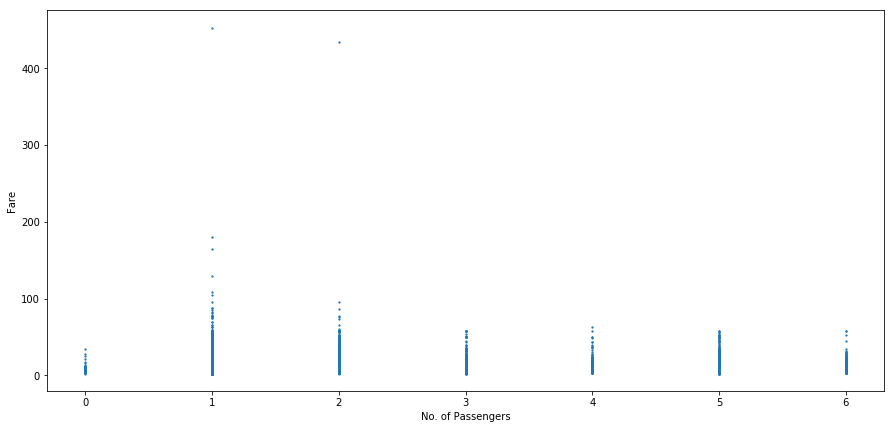

In [46]:
plt.figure(figsize=(15,7))
plt.scatter(x=train['passenger_count'], y=train['fare_amount'], s=1.5)
plt.xlabel('No. of Passengers')
plt.ylabel('Fare');

From the above 2 graphs we see that the single passengers are more frequent travellers. The highest fare amount is also payed  by them

#### 2. Does the Hour affect the fare_amount

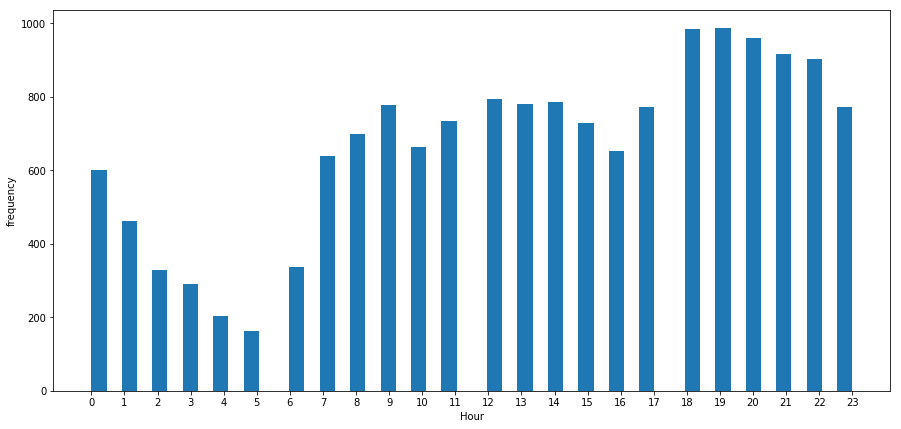

In [47]:
plt.figure(figsize=(15,7))
plt.hist(train['Hour'] , bins= 50)
plt.xlabel('Hour')
plt.ylabel('frequency')
plt.xticks(range(0,24 ));

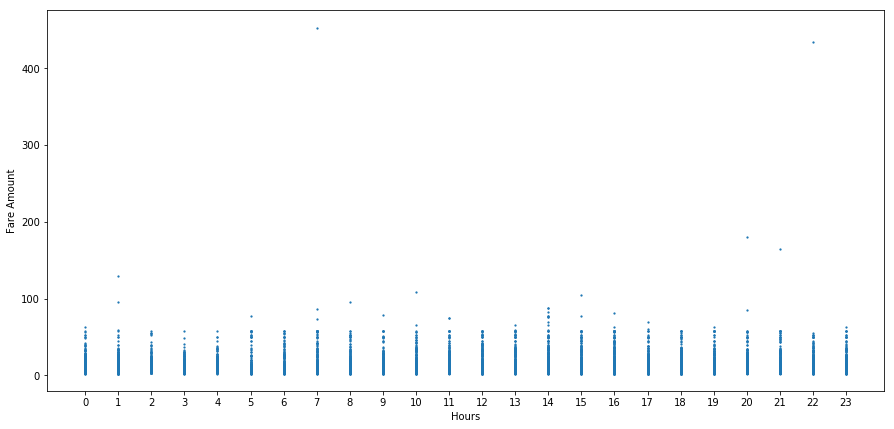

In [48]:
plt.figure(figsize=(15,7))
plt.scatter(x=train['Hour'], y=train['fare_amount'], s=1.5)
plt.xlabel('Hours')
plt.ylabel('Fare Amount')
plt.xticks(range(0, 24));

From the above two graphs we see that the frequency of the cabs is lowest at 5 AM in the morning and highest at 7PM in the evening

The highest fare amount is noted at 7 AM

#### 3. Does the Month affect the fare_amount

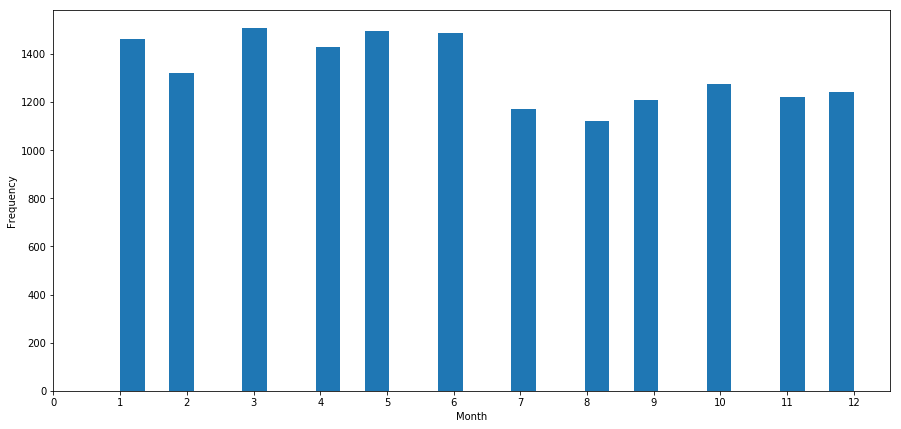

In [49]:
plt.figure(figsize=(15,7))
plt.hist(train['Month'], bins=30)
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.xticks(range(0, 13));

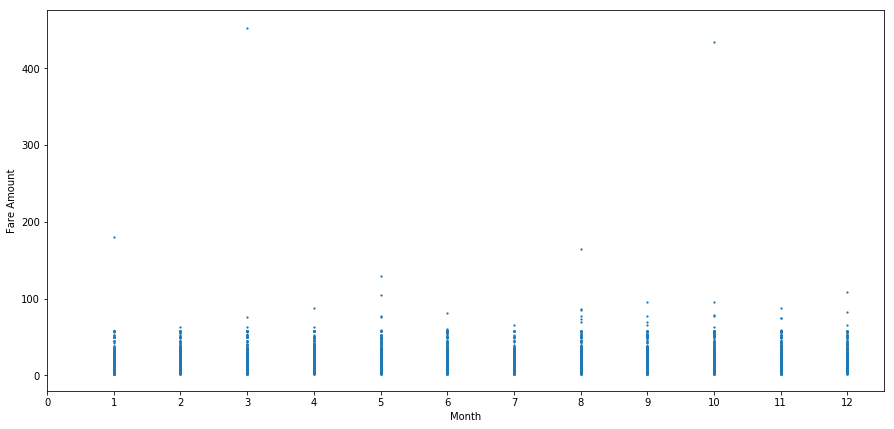

In [50]:
plt.figure(figsize=(15,7))
plt.scatter(x=train['Month'], y=train['fare_amount'], s=1.5)
plt.xlabel('Month')
plt.ylabel('Fare Amount')
plt.xticks(range(0, 13));

From the two graphs above we see that the frequency of the cabs is highest in March. Also the highest fare is also noted in the same month

#### 4. Does Day affect the fare_amount

Text(0, 0.5, 'Frequency')

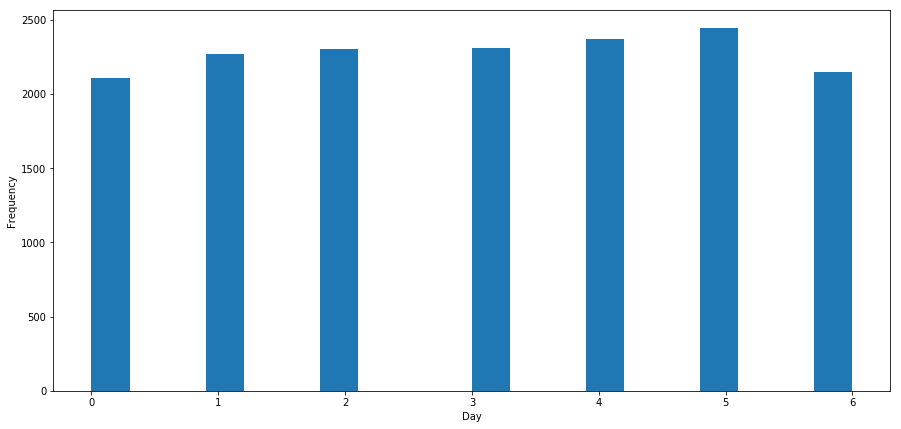

In [51]:
plt.figure(figsize=(15,7))
plt.hist(train['Day'], bins=20)
plt.xlabel('Day')
plt.ylabel('Frequency')

Text(0, 0.5, 'Fare Amount')

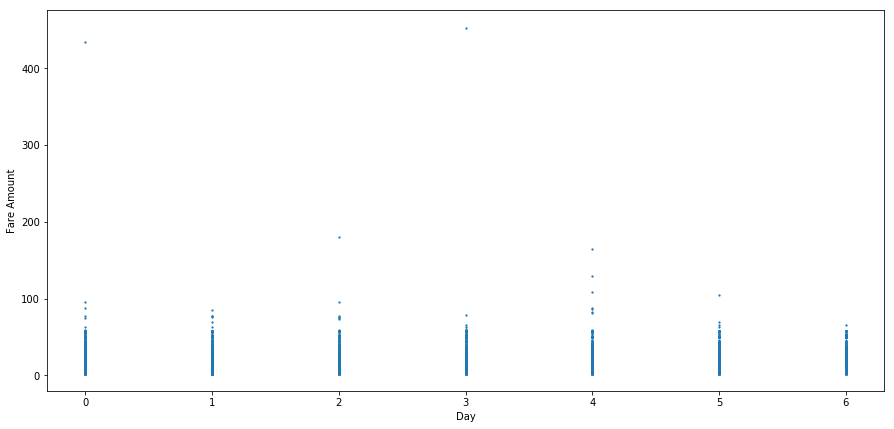

In [52]:
plt.figure(figsize=(15,7))
plt.scatter(x=train['Day'], y=train['fare_amount'], s=1.5)
plt.xlabel('Day')
plt.ylabel('Fare Amount')

We observe that the the frequency of cabs is highest on saturday and the highest fare was noted on thursday

#### 5. Does the year affect fare_amount

Text(0, 0.5, 'Frequency')

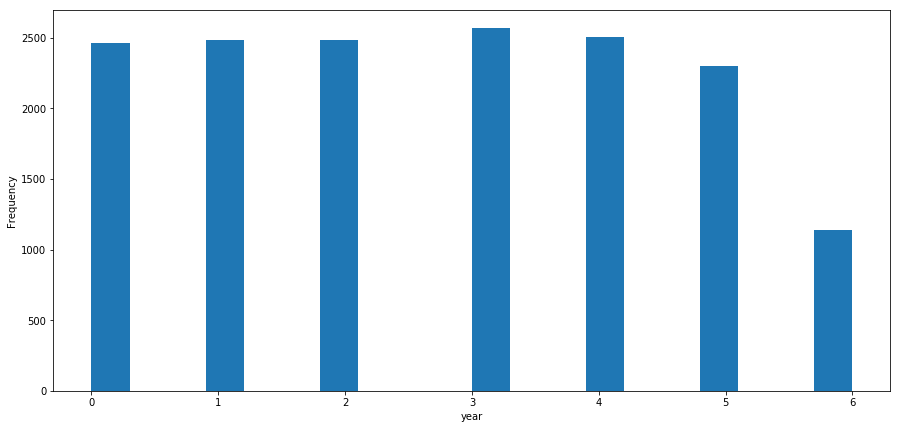

In [53]:
plt.figure(figsize=(15,7))
plt.hist(train['year'], bins=20)
plt.xlabel('year')
plt.ylabel('Frequency')

Text(0, 0.5, 'Fare Amount')

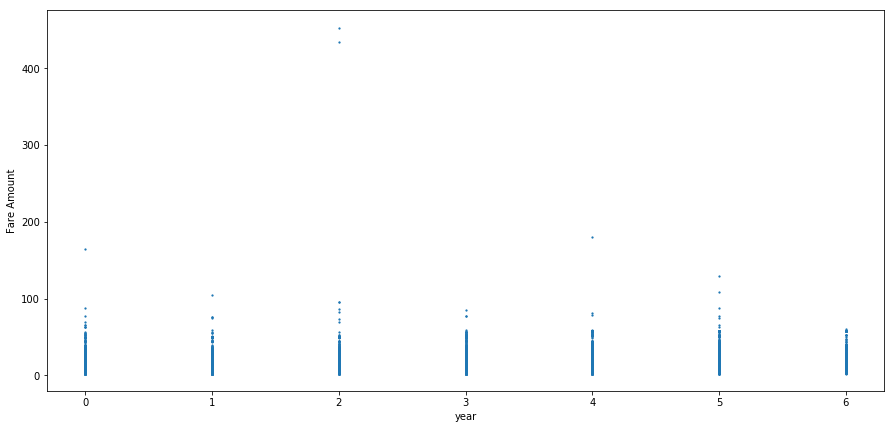

In [54]:
plt.figure(figsize=(15,7))
plt.scatter(x=train['year'], y=train['fare_amount'], s=1.5)
plt.xlabel('year')
plt.ylabel('Fare Amount')

The frequency of cabs taken seems to be decreasing from 2014 to 2015. In the previous years it is more or less the same

# Handling Skewness

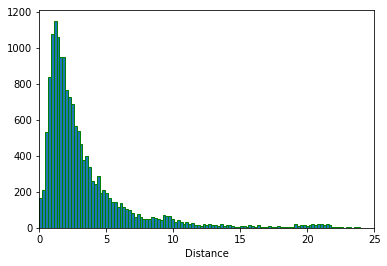

In [55]:
plt.hist(train['Distance'],bins = 'auto' ,ec='green')
plt.xlim(0,25)
plt.xlabel('Distance')
plt.show()

In [56]:
# some of the distances are 0. we cannot take the log. We decide to proceed by taking square root
train["Distance"] = np.sqrt(train["Distance"])
test["Distance"] = np.sqrt(test["Distance"])

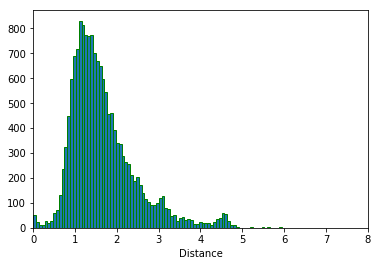

In [57]:
# checking if the skeweness is reduced
plt.hist(train['Distance'],bins = 'auto' ,ec='green')
plt.xlim(0,8)
plt.xlabel('Distance')
plt.show()

# Model Development

In [58]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(train.drop('fare_amount',axis=1),
                                               train['fare_amount'],
                                               test_size=0.2,
                                               random_state=3)

In [59]:
# Calculate MAPE
def MAPE(y_true, y_pred):
    mape = np.mean(np.abs((y_true-y_pred)/y_true))
    return mape

### Linear Regression

In [60]:
linearRegressionModel = LinearRegression()
linearRegressionModel.fit(x_train,y_train)
linearRegressionModel_predictions = linearRegressionModel.predict(x_test)

In [61]:
print("MAE for Linear Regression is ",mean_absolute_error(y_test,linearRegressionModel_predictions))
print("MAPE for Linear Regression is ",MAPE(y_test,linearRegressionModel_predictions))
print("MSE for Linear Regression is ",mean_squared_error(y_test,linearRegressionModel_predictions))
print("RMSE for Linear Regression is ",np.sqrt(mean_squared_error(y_test,linearRegressionModel_predictions)))

MAE for Linear Regression is  2.794141787382295
MAPE for Linear Regression is  0.2769475988349314
MSE for Linear Regression is  24.46193450755993
RMSE for Linear Regression is  4.945900778175795


### Decision tree

In [62]:
dtree_model = DecisionTreeRegressor(random_state=42)
dtree_model.fit(x_train,y_train)
dtree_predictions = dtree_model.predict(x_test)

In [63]:
print("MAE for decision tree regressor is ",mean_absolute_error(y_test,dtree_predictions))
print("MAPE for decision tree regressor is ",MAPE(y_test,dtree_predictions))
print("MSE for decision tree regressor is ",mean_squared_error(y_test,dtree_predictions))
print("RMSE for decision tree regressor is ",np.sqrt(mean_squared_error(y_test,dtree_predictions)))

MAE for decision tree regressor is  2.9344116724192033
MAPE for decision tree regressor is  0.2809281968685263
MSE for decision tree regressor is  29.387060338876687
RMSE for decision tree regressor is  5.420983336893473


##### Decision Tree Hyperparameter tuning

In [64]:
kf = KFold(n_splits= 3 , random_state=42)
params_dict = {
              'min_samples_leaf': list(range(1,20,2)),
              'max_features': list(range(1,7))
              }

dtree_tune=GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),
                        param_grid=params_dict ,
                        cv = kf,
                        scoring='neg_mean_squared_error',
                        verbose=6000)
dtree_tune.fit(x_train,y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] max_features=1, min_samples_leaf=1 ..............................
[CV]  max_features=1, min_samples_leaf=1, score=-156.302, total=   0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[CV] max_features=1, min_samples_leaf=1 ..............................
[CV]  max_features=1, min_samples_leaf=1, score=-58.647, total=   0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[CV] max_features=1, min_samples_leaf=1 ..............................
[CV]  max_features=1, min_samples_leaf=1, score=-139.098, total=   0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[CV] max_features=1, min_samples_leaf=3 ..............................
[CV]  max_features=1, min_samples_leaf=3, score=-136.326, total=   0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | el

[CV]  max_features=2, min_samples_leaf=5, score=-38.409, total=   0.0s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:    0.3s remaining:    0.0s
[CV] max_features=2, min_samples_leaf=5 ..............................
[CV]  max_features=2, min_samples_leaf=5, score=-32.246, total=   0.0s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:    0.3s remaining:    0.0s
[CV] max_features=2, min_samples_leaf=7 ..............................
[CV]  max_features=2, min_samples_leaf=7, score=-120.443, total=   0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.4s remaining:    0.0s
[CV] max_features=2, min_samples_leaf=7 ..............................
[CV]  max_features=2, min_samples_leaf=7, score=-40.595, total=   0.0s
[Parallel(n_jobs=1)]: Done  41 out of  41 | elapsed:    0.4s remaining:    0.0s
[CV] max_features=2, min_samples_leaf=7 ..............................
[CV]  max_features=2, min_samples_leaf=7, score=-35.380, total=   0.0s
[Parallel(n_jobs=1)]: Done  42 out of  4

[CV] max_features=3, min_samples_leaf=17 .............................
[CV]  max_features=3, min_samples_leaf=17, score=-117.706, total=   0.0s
[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed:    1.0s remaining:    0.0s
[CV] max_features=3, min_samples_leaf=17 .............................
[CV]  max_features=3, min_samples_leaf=17, score=-39.681, total=   0.0s
[Parallel(n_jobs=1)]: Done  86 out of  86 | elapsed:    1.0s remaining:    0.0s
[CV] max_features=3, min_samples_leaf=17 .............................
[CV]  max_features=3, min_samples_leaf=17, score=-22.806, total=   0.0s
[Parallel(n_jobs=1)]: Done  87 out of  87 | elapsed:    1.0s remaining:    0.0s
[CV] max_features=3, min_samples_leaf=19 .............................
[CV]  max_features=3, min_samples_leaf=19, score=-116.948, total=   0.0s
[Parallel(n_jobs=1)]: Done  88 out of  88 | elapsed:    1.0s remaining:    0.0s
[CV] max_features=3, min_samples_leaf=19 .............................
[CV]  max_features=3, min_samples_l

[CV]  max_features=5, min_samples_leaf=5, score=-31.846, total=   0.0s
[Parallel(n_jobs=1)]: Done 129 out of 129 | elapsed:    1.8s remaining:    0.0s
[CV] max_features=5, min_samples_leaf=7 ..............................
[CV]  max_features=5, min_samples_leaf=7, score=-118.225, total=   0.0s
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    1.9s remaining:    0.0s
[CV] max_features=5, min_samples_leaf=7 ..............................
[CV]  max_features=5, min_samples_leaf=7, score=-34.959, total=   0.0s
[Parallel(n_jobs=1)]: Done 131 out of 131 | elapsed:    1.9s remaining:    0.0s
[CV] max_features=5, min_samples_leaf=7 ..............................
[CV]  max_features=5, min_samples_leaf=7, score=-27.239, total=   0.0s
[Parallel(n_jobs=1)]: Done 132 out of 132 | elapsed:    1.9s remaining:    0.0s
[CV] max_features=5, min_samples_leaf=9 ..............................
[CV]  max_features=5, min_samples_leaf=9, score=-117.967, total=   0.0s
[Parallel(n_jobs=1)]: Done 133 out of 1

[CV]  max_features=6, min_samples_leaf=11, score=-116.617, total=   0.0s
[Parallel(n_jobs=1)]: Done 166 out of 166 | elapsed:    2.7s remaining:    0.0s
[CV] max_features=6, min_samples_leaf=11 .............................
[CV]  max_features=6, min_samples_leaf=11, score=-31.104, total=   0.0s
[Parallel(n_jobs=1)]: Done 167 out of 167 | elapsed:    2.7s remaining:    0.0s
[CV] max_features=6, min_samples_leaf=11 .............................
[CV]  max_features=6, min_samples_leaf=11, score=-21.574, total=   0.0s
[Parallel(n_jobs=1)]: Done 168 out of 168 | elapsed:    2.8s remaining:    0.0s
[CV] max_features=6, min_samples_leaf=13 .............................
[CV]  max_features=6, min_samples_leaf=13, score=-116.533, total=   0.0s
[Parallel(n_jobs=1)]: Done 169 out of 169 | elapsed:    2.8s remaining:    0.0s
[CV] max_features=6, min_samples_leaf=13 .............................
[CV]  max_features=6, min_samples_leaf=13, score=-29.983, total=   0.0s
[Parallel(n_jobs=1)]: Done 170 out

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=False),
             error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=42,
                                             splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_features': [1, 2, 3, 4, 5, 6],
                         'min_samples_leaf': [1, 3, 5, 7, 9, 11, 13, 15, 17,
               

In [65]:
dtree_tune.best_estimator_

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=6,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=19,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [66]:
dtree_tuned_predictions=dtree_tune.predict(x_test)

print("MAE after decision tree after hyperparameter tuning is ",mean_absolute_error(y_test,dtree_tuned_predictions))
print("MAPE after decision tree after hyperparameter tuning is ",MAPE(y_test,dtree_tuned_predictions))
print("MSE after decision tree after hyperparameter tuning is ",mean_squared_error(y_test,dtree_tuned_predictions))
print("RMSE after decision tree after hyperparameter tuning is ",
      np.sqrt(mean_squared_error(y_test,dtree_tuned_predictions)))

MAE after decision tree after hyperparameter tuning is  2.341356860136691
MAPE after decision tree after hyperparameter tuning is  0.231902852899584
MSE after decision tree after hyperparameter tuning is  21.23701243505393
RMSE after decision tree after hyperparameter tuning is  4.608363314133764


### Random Forest

In [67]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(x_train,y_train)
rf_predictions = rf_model.predict(x_test)

In [68]:
print("MAE for random forest regressor is ",mean_absolute_error(y_test,rf_predictions))
print("MAPE for random forest regressor is ",MAPE(y_test,rf_predictions))
print("MSE for random forest regressor is ",mean_squared_error(y_test,rf_predictions))
print("RMSE for random forest regressor is ",np.sqrt(mean_squared_error(y_test,rf_predictions)))

MAE for random forest regressor is  2.3919880765610295
MAPE for random forest regressor is  0.25216728324460813
MSE for random forest regressor is  22.89173483150298
RMSE for random forest regressor is  4.784530784884029


##### Random Forest Hyperparameter Tuning

In [69]:
#for random forest regresion.

kf = KFold(n_splits= 3 , random_state=42)

param_grid={'n_estimators':[100,200,300,400,500],'max_features':list(range(1,7)),'max_depth': [4,6,8]}

rf_tune=GridSearchCV(RandomForestRegressor(random_state=42),
                     param_grid=param_grid ,
                     cv=kf ,
                     verbose= 6000)

rf_tune.fit(x_train,y_train)

Fitting 3 folds for each of 90 candidates, totalling 270 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] max_depth=4, max_features=1, n_estimators=100 ...................
[CV]  max_depth=4, max_features=1, n_estimators=100, score=0.225, total=   0.2s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[CV] max_depth=4, max_features=1, n_estimators=100 ...................
[CV]  max_depth=4, max_features=1, n_estimators=100, score=0.450, total=   0.2s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[CV] max_depth=4, max_features=1, n_estimators=100 ...................
[CV]  max_depth=4, max_features=1, n_estimators=100, score=0.537, total=   0.2s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s
[CV] max_depth=4, max_features=1, n_estimators=200 ...................
[CV]  max_depth=4, max_features=1, n_estimators=200, score=0.226, total=   0.4s
[Parallel(n_j

[CV]  max_depth=4, max_features=3, n_estimators=200, score=0.781, total=   0.7s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   29.0s remaining:    0.0s
[CV] max_depth=4, max_features=3, n_estimators=300 ...................
[CV]  max_depth=4, max_features=3, n_estimators=300, score=0.354, total=   1.1s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:   30.0s remaining:    0.0s
[CV] max_depth=4, max_features=3, n_estimators=300 ...................
[CV]  max_depth=4, max_features=3, n_estimators=300, score=0.700, total=   1.1s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:   31.1s remaining:    0.0s
[CV] max_depth=4, max_features=3, n_estimators=300 ...................
[CV]  max_depth=4, max_features=3, n_estimators=300, score=0.780, total=   1.1s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:   32.2s remaining:    0.0s
[CV] max_depth=4, max_features=3, n_estimators=400 ...................
[CV]  max_depth=4, max_features=3, n_estimators=400, score=0.355, total=   1

[CV]  max_depth=4, max_features=5, n_estimators=400, score=0.802, total=   2.4s
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  1.4min remaining:    0.0s
[CV] max_depth=4, max_features=5, n_estimators=500 ...................
[CV]  max_depth=4, max_features=5, n_estimators=500, score=0.374, total=   2.6s
[Parallel(n_jobs=1)]: Done  73 out of  73 | elapsed:  1.4min remaining:    0.0s
[CV] max_depth=4, max_features=5, n_estimators=500 ...................
[CV]  max_depth=4, max_features=5, n_estimators=500, score=0.711, total=   2.9s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:  1.5min remaining:    0.0s
[CV] max_depth=4, max_features=5, n_estimators=500 ...................
[CV]  max_depth=4, max_features=5, n_estimators=500, score=0.802, total=   2.7s
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  1.5min remaining:    0.0s
[CV] max_depth=4, max_features=6, n_estimators=100 ...................
[CV]  max_depth=4, max_features=6, n_estimators=100, score=0.375, total=   0

[CV]  max_depth=6, max_features=2, n_estimators=100, score=0.774, total=   0.5s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  2.2min remaining:    0.0s
[CV] max_depth=6, max_features=2, n_estimators=200 ...................
[CV]  max_depth=6, max_features=2, n_estimators=200, score=0.356, total=   0.9s
[Parallel(n_jobs=1)]: Done 109 out of 109 | elapsed:  2.2min remaining:    0.0s
[CV] max_depth=6, max_features=2, n_estimators=200 ...................
[CV]  max_depth=6, max_features=2, n_estimators=200, score=0.708, total=   0.9s
[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:  2.2min remaining:    0.0s
[CV] max_depth=6, max_features=2, n_estimators=200 ...................
[CV]  max_depth=6, max_features=2, n_estimators=200, score=0.777, total=   0.7s
[Parallel(n_jobs=1)]: Done 111 out of 111 | elapsed:  2.3min remaining:    0.0s
[CV] max_depth=6, max_features=2, n_estimators=300 ...................
[CV]  max_depth=6, max_features=2, n_estimators=300, score=0.354, total=   1

[CV]  max_depth=6, max_features=4, n_estimators=300, score=0.798, total=   1.7s
[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:  3.1min remaining:    0.0s
[CV] max_depth=6, max_features=4, n_estimators=400 ...................
[CV]  max_depth=6, max_features=4, n_estimators=400, score=0.379, total=   2.9s
[Parallel(n_jobs=1)]: Done 145 out of 145 | elapsed:  3.1min remaining:    0.0s
[CV] max_depth=6, max_features=4, n_estimators=400 ...................
[CV]  max_depth=6, max_features=4, n_estimators=400, score=0.711, total=   2.4s
[Parallel(n_jobs=1)]: Done 146 out of 146 | elapsed:  3.2min remaining:    0.0s
[CV] max_depth=6, max_features=4, n_estimators=400 ...................
[CV]  max_depth=6, max_features=4, n_estimators=400, score=0.800, total=   2.8s
[Parallel(n_jobs=1)]: Done 147 out of 147 | elapsed:  3.2min remaining:    0.0s
[CV] max_depth=6, max_features=4, n_estimators=500 ...................
[CV]  max_depth=6, max_features=4, n_estimators=500, score=0.379, total=   3

[CV]  max_depth=6, max_features=6, n_estimators=500, score=0.777, total=   4.4s
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  4.6min remaining:    0.0s
[CV] max_depth=8, max_features=1, n_estimators=100 ...................
[CV]  max_depth=8, max_features=1, n_estimators=100, score=0.322, total=   0.4s
[Parallel(n_jobs=1)]: Done 181 out of 181 | elapsed:  4.6min remaining:    0.0s
[CV] max_depth=8, max_features=1, n_estimators=100 ...................
[CV]  max_depth=8, max_features=1, n_estimators=100, score=0.630, total=   0.4s
[Parallel(n_jobs=1)]: Done 182 out of 182 | elapsed:  4.6min remaining:    0.0s
[CV] max_depth=8, max_features=1, n_estimators=100 ...................
[CV]  max_depth=8, max_features=1, n_estimators=100, score=0.700, total=   0.3s
[Parallel(n_jobs=1)]: Done 183 out of 183 | elapsed:  4.6min remaining:    0.0s
[CV] max_depth=8, max_features=1, n_estimators=200 ...................
[CV]  max_depth=8, max_features=1, n_estimators=200, score=0.323, total=   0

[CV]  max_depth=8, max_features=3, n_estimators=200, score=0.798, total=   1.2s
[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed:  5.3min remaining:    0.0s
[CV] max_depth=8, max_features=3, n_estimators=300 ...................
[CV]  max_depth=8, max_features=3, n_estimators=300, score=0.379, total=   2.1s
[Parallel(n_jobs=1)]: Done 217 out of 217 | elapsed:  5.4min remaining:    0.0s
[CV] max_depth=8, max_features=3, n_estimators=300 ...................
[CV]  max_depth=8, max_features=3, n_estimators=300, score=0.733, total=   2.1s
[Parallel(n_jobs=1)]: Done 218 out of 218 | elapsed:  5.4min remaining:    0.0s
[CV] max_depth=8, max_features=3, n_estimators=300 ...................
[CV]  max_depth=8, max_features=3, n_estimators=300, score=0.800, total=   1.7s
[Parallel(n_jobs=1)]: Done 219 out of 219 | elapsed:  5.4min remaining:    0.0s
[CV] max_depth=8, max_features=3, n_estimators=400 ...................
[CV]  max_depth=8, max_features=3, n_estimators=400, score=0.379, total=   2

[CV]  max_depth=8, max_features=5, n_estimators=400, score=0.741, total=   4.2s
[Parallel(n_jobs=1)]: Done 252 out of 252 | elapsed:  6.9min remaining:    0.0s
[CV] max_depth=8, max_features=5, n_estimators=500 ...................
[CV]  max_depth=8, max_features=5, n_estimators=500, score=0.380, total=   4.9s
[Parallel(n_jobs=1)]: Done 253 out of 253 | elapsed:  6.9min remaining:    0.0s
[CV] max_depth=8, max_features=5, n_estimators=500 ...................
[CV]  max_depth=8, max_features=5, n_estimators=500, score=0.660, total=   4.7s
[Parallel(n_jobs=1)]: Done 254 out of 254 | elapsed:  7.0min remaining:    0.0s
[CV] max_depth=8, max_features=5, n_estimators=500 ...................
[CV]  max_depth=8, max_features=5, n_estimators=500, score=0.738, total=   4.7s
[Parallel(n_jobs=1)]: Done 255 out of 255 | elapsed:  7.1min remaining:    0.0s
[CV] max_depth=8, max_features=6, n_estimators=100 ...................
[CV]  max_depth=8, max_features=6, n_estimators=100, score=0.379, total=   1

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=False),
             error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=Non

In [70]:
rf_tune.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
                      max_features=3, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=300,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [71]:
rf_tuned_predictions=rf_tune.predict(x_test)

print("MAE after random forest hyperparameter tuning is ",mean_absolute_error(y_test,rf_tuned_predictions))
print("MAPE after random forest hyperparameter tuning is ",MAPE(y_test,rf_tuned_predictions))
print("MSE after random forest hyperparameter tuning is ",mean_squared_error(y_test,rf_tuned_predictions))
print("RMSE after random forest hyperparameter tuning is ",np.sqrt(mean_squared_error(y_test,rf_tuned_predictions)))

MAE after random forest hyperparameter tuning is  2.1795720880373306
MAPE after random forest hyperparameter tuning is  0.2311267646579907
MSE after random forest hyperparameter tuning is  17.33209256891075
RMSE after random forest hyperparameter tuning is  4.1631829852783016


### Gradient Boosting Regression

In [72]:
gbr_model = GradientBoostingRegressor(random_state=42)
gbr_model.fit(x_train,y_train)
gbr_predictions = gbr_model.predict(x_test)

In [73]:
print("MAE for gradient boosting regressor is ",mean_absolute_error(y_test,gbr_predictions))
print("MAPE for gradient boosting regressor is ",MAPE(y_test,gbr_predictions))
print("MSE for gradient boosting regressor is ",mean_squared_error(y_test,gbr_predictions))
print("RMSE for gradient boosting regressor is ",np.sqrt(mean_squared_error(y_test,gbr_predictions)))

MAE for gradient boosting regressor is  2.090227247178083
MAPE for gradient boosting regressor is  0.21154354785771226
MSE for gradient boosting regressor is  16.780220780515457
RMSE for gradient boosting regressor is  4.096366778074866


#### Gradient Boost Hyperparameter tuning

In [74]:
# gradient boost hyper parameter tuning

kf = KFold(n_splits= 3 , random_state=42)

gb_grid_params = {'learning_rate': [0.1],
              'n_estimators' : list(range(130,240,10))
              }

gbr_tuned = GridSearchCV(GradientBoostingRegressor(random_state=42),
                   gb_grid_params,
                   cv=kf,
                   verbose = 6000)

gbr_tuned.fit(x_train,y_train)

Fitting 3 folds for each of 11 candidates, totalling 33 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] learning_rate=0.1, n_estimators=130 .............................
[CV] . learning_rate=0.1, n_estimators=130, score=0.378, total=   0.3s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[CV] learning_rate=0.1, n_estimators=130 .............................
[CV] . learning_rate=0.1, n_estimators=130, score=0.735, total=   0.3s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[CV] learning_rate=0.1, n_estimators=130 .............................
[CV] . learning_rate=0.1, n_estimators=130, score=0.808, total=   0.3s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s
[CV] learning_rate=0.1, n_estimators=140 .............................
[CV] . learning_rate=0.1, n_estimators=140, score=0.377, total=   0.3s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapse

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=False),
             error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_we...
                                                 n_estimators=100,
                                               

In [75]:
gbr_tuned.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=130,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [76]:
gbr_tuned_predictions=gbr_tuned.predict(x_test)

print("MAE after GBR hyperparameter tuning is ",mean_absolute_error(y_test,gbr_tuned_predictions))
print("MAPE after GBR hyperparameter tuning is ",MAPE(y_test,gbr_tuned_predictions))
print("MSE after GBR hyperparameter tuning is ",mean_squared_error(y_test,gbr_tuned_predictions))
print("RMSE after GBR hyperparameter tuning is ",np.sqrt(mean_squared_error(y_test,gbr_tuned_predictions)))

MAE after GBR hyperparameter tuning is  2.077874495102081
MAPE after GBR hyperparameter tuning is  0.20961845254503678
MSE after GBR hyperparameter tuning is  16.60020708962114
RMSE after GBR hyperparameter tuning is  4.074335171487631


#### We observe that Gradient Boost Regression performs the best. Hence we use it to make predictions on the test dataset

In [77]:
gbr_final_test_predictions = gbr_tuned.predict(test)

In [78]:
test["Predicted Fare Amount"] = gbr_final_test_predictions

In [79]:
test.loc[(test["Predicted Fare Amount"] < 2.5),'Predicted Fare Amount'] = 2.5

In [80]:
test.to_csv("Predictions in Python.csv" , index = False)